# Basic End-to-End Test

Bobby Pascua, Steven Murray, Nick Kern, Jacob Burba, Josh Dillon, and the HERA Validation Team

## Setup and Metadata

### Abstract

This test combines the processes and knowledge built up over Steps -1 through 3 into an integrated test of the end-to-end pipeline, at a basic level. In particular, this tests each pipeline component *under its own ideal assumptions*. Furthermore, it does *not* test the `xrfi` component. 

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import defaultdict

import copy
import glob
import itertools
import pathlib
import os
import re
import sys

import astropy
from astropy import constants
from astropy import units
import h5py

import hera_cal
import hera_pspec
import hera_sim
import pyuvdata
import uvtools

from pyuvdata import UVData, UVBeam
from hera_cal import io
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH
from uvtools.dspec import gen_window
from uvtools.utils import FFT, fourier_freqs
from uvtools.plot import waterfall

sys.path.append("../../")
import template_tools
import tools

if hera_sim.version.version.startswith('0'):
    from hera_sim.rfi import _listify
else:
    from hera_sim.utils import _listify

/users/rpascua/hera_packages/hera_sim/hera_sim/__init__.py:35: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of interfacing with the hera_sim package features.
  FutureWarning)


### Description

In [2]:
print(f'Last executed: {str(datetime.now())}')

Last executed: 2020-04-10 22:43:58.697683


- **Major Step Description:** Simulate all components of a realistic observation, and enact an analysis pipeline in the same way as for a real IDR.
- **Minor Variation Description:** 
  - EoR: $P(k) = A_0 k^{-2}$ (amplified, frequency dependent) simulated with `RIMEz`. (ala `0.2.0`)
  - FG: GLEAM + eGSM + brights, simulated with `RIMEz` (ala `1.2.0`)
  - Sky Simulation Format: 
    - Idealized H1C Antenna positions (perfect redundancy)
    - Identical Fagnoni beam applied to each baseline.
    - Full frequency coverage of H1C
    - Times of observation rephased from original LSTs to match 10 chosen days of H1C IDR2.2, for 6 hours per day.
  - Systematics (in order of application):
    - Thermal noise from autocorrelations using `hera_sim`.
    - Gains (linear drift with time, repeating per night) from `hera_sim` (ala `2.1.0`)
    - Cable reflections from `hera_sim` (ala `3.2.0`).
    - Cross-coupling from `hera_sim` (ala `3.2.0`).
  - RFI *flags* applied to post-calibrated data (ala `3.1.0`). Flags drawn from the matched 10 days of actual H1C IDR2.2 data.
- **Pipelines Tested:** `firstcal`, `redcal`, `abscal`, `smoothcal`, `in-painting` `systematics_removal`, `pspec`
- **Criteria**:
  1. Residuals to averaged input EoR-only P(k) within 1% on scales of interest.

### Software

In [3]:
template_tools.print_dep_versions(extras=['astropy', 'hera_cal'], ignore=['healvis'])

Module pyuvdata   ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_stats ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_sim   ....	Version 0.1.0  .......	Git b'6cd21e2684867d90c2105d4287718a97af9767c4'
Module hera_qm    ....	Version 1.0    .......	Git 597ec3b498ce1b30cbef2736df1addfc4a6b9ffe
Module hera_pspec ....	Version 0.2.0  .......	Git dad85a51adb57501dc24081cd7ea9687cf512e7c
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git b931bc98a92132a49dc4a2c0421396d3cd59a063
Module numpy      ....	Version 1.17.4 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None
Module h5py       ....	Version 2.9.0  .......	Git None
Module astropy    ....	Version 4.0    .......	Git None
Module hera_cal   ....	Version 2.0    .......	Git 2e5dd382872f649266f334e9f3ded4fc4803f017


### Data

The data directly used in this notebook have been prepared externally by scripts found in this directory (see [Data Preparation](#data-preparation)). To maintain data provenance for the test, we here describe the paths to all relevant data (even data that is not used directly).

The root directory where all validation data lives (on NRAO lustre):

In [4]:
root_path = pathlib.Path("/lustre/aoc/projects/hera/Validation")

The original sky-based simulations (unphased, and compressed to a single baseline per baseline group) are found in the following paths:

In [5]:
data_prefix = 'hera_hex37_100-200MHz_HERA_dipole_'

original_eor_path = root_path / (data_prefix + 'beam_pow_neg2_pspec/realization_0.uvh5')
original_gleam_path = root_path / (data_prefix + 'full_gleam_plus_brights_v01') / 'hera_hex37_full_gleam_plus_brights_v01.uvh5'
original_gsm_path = root_path / (data_prefix + 'eGSM_preview') / 'hera_hex37_egsm_preview.uvh5'

assert original_eor_path.exists()
assert original_gleam_path.exists()
assert original_gsm_path.exists()

print("Base EOR Simulation:\n", original_eor_path)
print("\nBase GLEAM Simulation:\n", original_gleam_path)
print("\nBase eGSM Simulation:\n", original_gsm_path)

Base EOR Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5

Base GLEAM Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5

Base eGSM Simulation:
 /lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5


Note however that the EoR simulation is amplified by a factor of 10 (in visibility units) and a frequency-dependence applied when creating the chunked files used throughout this notebook.

The files produced by the [data preparation](#data-preparation) are found in the following locations:

In [6]:
test_path = root_path / 'test-4.0.0'
data_path = test_path / 'data'

vis_path = data_path / "visibilities"
gain_path = data_path / "gains"

# Path to beam normalization data
omegas_data_path = root_path / 'HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert omegas_data_path.exists()

Within the `visibilities` directory are many files&mdash;one for each time, sky component (`foregrounds` or `sum`), and state of corruption (`true`, `corrupted`). The following function retrieves a path corresponding to a query mixing these states (or a list of such files):

In [7]:
def get_vis_files(jd_major='*', jd_minor='*', sky='*', state='*', jd=None):
    if jd:
        jd_major, jd_minor = str(jd).split('.')
        
    assert sky in ("foregrounds", "sum", "eor")
    assert state in ("true", "corrupted")
    
    files = glob.glob(str(vis_path / f"zen.{jd_major}.{jd_minor}.{sky}.{state}.uvh5"))
    if len(files) == 1:
        return files[0]
    else:
        return sorted(files)

Finally, the analysis performed in this test produces some files (mostly spectra) in the following directories:

In [8]:
spec_path = test_path / 'spectra'

## Data Preparation

< Define the exact flow of operations used to prepare the simulated data files, using the `tools` subpackage >

We begin with three sets of simulation files, compressed by redundancy, located in {{str(vis_path)}}: `eor.uvh5`, `foregrounds.uvh5`, and `sum.uvh5`. `eor.uvh5` contains the visibilities simulated for a $k^{-2}$ power spectrum which have been amplified and given some frequency scaling. `foregrounds.uvh5` contains the sum of the diffuse and point-source foreground visibilities, with the diffuse foreground visibilities using the eGSM and the point-source foreground visibilities using the GLEAM catalog with bright sources added. `sum.uvh5` simply contains the sum of these two sets of visibilities. The original data files used to create these files were produced using the `RIMEz` simulator. We will run three sets of data through the analysis and power spectrum pipeline:
1. Data whose sky component only includes foreground emission, which has been corrupted with simulated systematic effects. (i.e. using `foregrounds.uvh5` and simulating systematics with `hera_sim`.)
2. Data whose sky component includes both foreground emission and mock emission from reionization, which has not been corrupted in any way. (i.e. using `sum.uvh5` and not adding any systematics.)
3. The same as (2), but with systematics added. The systematics will not be identical to the systematics introduced to the data in (1), but will be statistically similar. (i.e. using `sum.uvh5` and simulating systematics with `hera_sim`.)

The precise details of the simulation preparation are a bit more complicated than the above section would suggest. Each of the base simulation files (`eor.uvh5`, `foregrounds.uvh5`, and `sum.uvh5`) will be used to create a set of data similar to the observational data used for the H1C upper-limits paper&mdash;we will be producing the same number of files, modifying the data and metadata from the simulation files to agree with the observing parameters for each good day from H1C IDR2, and simulating all of the systematic effects that we expect to be present in the real data and that we are confident in our ability to simulate in a realistic way.

The first step in the simulation data preparation is adjusting the simulated data/metadata to agree with the observing parameters for each of the chosen days from H1C IDR2, inflating the compressed simulation data, chunking the modified data into files with the same number of integrations as each file in the H1C IDR2 data release, and writing the results to disk. This proceeds as follows:
1. Load in the raw simulation data (one of `eor.uvh5`, `foregrounds.uvh5`, or `sum.uvh5`).
2. Load in the metadata from a given day of observation from H1C IDR2.
3. Perform a downselection in time on the raw simulation data by matching LSTs between the two sets of data.
4. Rephase the downselected simulation data to exactly match the LSTs from the observational data. (Steps (3) and (4) are performed by `tools.sim_prep.rephase_to_reference`.)
5. Identify and select only a subset of antennas to use from the simulation data and the observational data such that the set of unique baselines for each subset agrees with the other to some tolerance (default 1 meter in each component).
6. Perform a downselection on the simulation data and observational metadata to include only the antennas satisfying (5).
7. Modify the telescope metadata for the simulation data (antenna positions, numbers, and telescope location) such that it agrees exactly with the observational data.
8. Accordingly modify the simulation data array (this is effectively just a re-indexing of the simulation data array). (Steps (5) through (8) are performed by `tools.sim_prep.downselect_antennas`.)
9. Chunk the remaining simulation data into files identical in size to the observational data files and write the results to disk. (This is performed by `tools.sim_prep.chunk_sim_and_save`.)  

All of the above steps are performed by `tools.sim_prep.adjust_sim_to_data`.

For the perfectly calibrated (or, equivalently, uncorrupted) simulation data, no further actions are taken before pushing the data through the validation pipeline. For the corrupted data, we add systematic effects as follows:
1. Using `tools.sim_prep.add_noise`, which effectively wraps `hera_sim.noise.thermal_noise`, simulate thermal noise and add it to the simulation data.
2. Using `tools.sim_prep.add_gains`, which is a thin wrapper for `hera_sim.sigchain.gen_gains`, simulate per-antenna bandpass gains and apply them to the simulation data. Currently the gains are time-independent over the course of a night, but this is subject to change.
3. Using `tools.sim_prep.add_reflections`, which wraps `hera_sim.sigchain.gen_reflection_gains`, simulate per-antenna reflection gains and apply them to the data. The reflections are inserted at a delay of about 1200 ns, with some jitter up to about 30 ns, with an amplitude of $10^{-3}$, again with some jitter added, but this time with a standard deviation of one part in $10^4$. Each reflection comes in with a random phase, and all reflections are time-independent over the course of the night (though this is also subject to change).
4. Using `tools.sim_prep.add_xtalk`, which wraps `hera_sim.sigchain.gen_cross_coupling_xtalk`, insert a spectrum of cross-coupling crosstalk into all of the cross-correlation visibilities. The spectrum consists of N crosstalk realizations per visibility, each of which show up at a single delay. By default, we use 10 realizations per baseline which are inserted at delays that are uniformly spaced between 900 and 1300 ns. Each realization of crosstalk has its delay randomized by about 1% (i.e. a realization that is nominally at 900 ns may actually be inserted somewhere between roughly 890 ns and 910 ns). The spectrum of crosstalk for a given baseline is introduced with a log-uniform range of amplitudes from $10^{-4}$ to $10^{-6}$, where the amplitude is a coefficient that scales down the autocorrelation that is broadcast to the cross-correlation. These amplitudes are also given some jitter at the $10^{-4}$ level, practically identical to the way it is done with reflections. Each realization of crosstalk is given a random phase and is inserted symmetrically in delay space.
5. After performing absolute calibration on the corrupted data, RFI flags from the H1C IDR2 data are applied to the calibration solutions.  

For clarity, we may write the final, corrupted visibility as:
$$
V_{ij}^{corrupted} = (g_ig_j^*)^{bandpass}(g_ig_j^*)^{reflections}V_{ij}^{noisy} + (1-\delta_{ij}) \sum_{k=1}^N A_{i,k}\mathrm{e}^{i\phi_{i,k}} \cos(2\pi\nu\tau_{i,k}) |g_i^{bandpass}|^2|g_i^{reflections}|^2V_{ii}^{noisy},
$$
where the $i,j$ subscripts refer to antenna numbers, $g_i$ is a complex gain term, and $\delta_{ij}$ is the Kronecker-Delta. Note that the term involving the sum is $V_{ij}^{xtalk}$, and the cosine term ensures that the crosstalk is symmetric in delay space. $V_{ij}^{noisy}$ is modeled as follows: first, define a frequency-dependent contribution to the visibility from the receiver temperature, $V_{ij}^{rx}$ (in principle, this should vary between antennas, but the current version of `tools.sim_prep.add_noise` does not implement that); add this term to the true visibility $V_{ij}^{true}$; divide the sum by the square root of the product of the channel width and the integration time $\sqrt{Bt_{int}}$; then do an element-wise multiplication of the resulting visibility waterfall with a similarly sized matrix whose entries are Gaussian random in their real and imaginary components. We may write this as 
$$
V_{ij}^{noisy} = N_{ij}\frac{V_{ij}^{true} + V_{ij}^{rx}}{\sqrt{Bt_{int}}}, 
$$
where $N_{ij}$ is the complex noise realization for the given baseline $\vec{b}_{ij}$. It is important to stress that $N_{ij}$ is uncorrelated in time and frequency, each baseline's noise realization is independent from every other baseline's noise realization, and noise is uncorrelated between polarizations.

## Extra Utility Functions

Some of these may be unnecessary, but they have been useful in previous Tests.

In [9]:
H0 = 67.74
h = H0/100.

cosmo = hera_pspec.conversions.Cosmo_Conversions(
    Om_L=0.6911,
    Om_b=0.02230/h**2,
    Om_c=0.1188/h**2,
    H0=H0,
)

In [10]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [11]:
def plot_spectra(uvp_avgs, labels, blps, spws=[0], polpair=('pI', 'pI'),
                 fig=None, ax=None, linestyles=None, linewidths=None,
                 colors=None, alpha=0.5, figsize=(10, 7)):
    
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvp_avgs) == len(labels)
    
    # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if linewidths is None:
        linewidths = [3.5] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
        
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            freq_range = uvp_avgs[0].get_spw_ranges(spws[j])[0][:2]
            
            k_paras = uvp_avgs[0].get_kparas(spws[j])
            analytic_spectrum = get_analytic_spectrum(uvp_avgs[0], spws[j])            
                                   
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Actually plot the spectra
            ax_plot.loglog(k_paras, np.abs(analytic_spectrum), ls=':', lw=2, color='#3F3F3F',
                           alpha=0.75, label='Analytic EoR')
            for k in range(len(uvp_avgs)):
                uvp_plot = uvp_avgs[k].get_data(key)
                ax_plot.loglog(k_paras, np.abs(uvp_plot[0]), ls=linestyles[k], lw=linewidths[k],
                               color=colors[k], alpha=alpha, label=labels[k])

            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=16)
            ax_plot.set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=16)
            ax_plot.set_title('spw: {:0.0f} - {:0.0f} MHz; '.format(freq_range[0] / 1e6, freq_range[1] / 1e6) +
                              'blp: {}; pol: {}'.format(key[1], key[2]), fontsize=14)
            ax_plot.legend(fontsize=12)

In [12]:
# this may need to be updated; check with Jacob re: test-3.1.0
def get_pspec(pspec_file):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    return uvp

In [13]:
def get_k_nyquist(uvp, spw=0):
    keys = uvp.get_all_keys()
    dly = uvp.get_dlys(spw)
    
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.

    spw_freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))

    return np.amax(tau_nyquist)*uvp.cosmo.tau_to_kpara(z_mean, little_h=True)

def aliased_power_spectrum(k, k_nyquist, z, freq_dep=False):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6
        
    return Pk * cosmo.h / (1 + z)**2

def get_analytic_spectrum(uvp, spw, freq_dep=False):
    # Get redshift of band center for scaling the aliased spectrum
    freq_range = uvp.get_spw_ranges(spw)[0][:2]
    center = (freq_range[0] + freq_range[1]) / 2
    z = 1420405751.7667 / center - 1
    k_paras = uvp.get_kparas(spw)
    k_nyquist = get_k_nyquist(uvp, spw=spw)
    
    return aliased_power_spectrum(k_paras, k_nyquist, z, freq_dep)

In [14]:
def plot_avg_spectra(spectra_avg, analytic, resid=False, xlim=None, ylim=None):
    # for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
    colors = ['#DA4E3B', '#3D5789', '#270B52']
    alphas = (0.5, 0.6, 0.6)

    linestyles = ('-', ':', '--', '-', '-', '-')
    lws = (4, 4, 4, 6, 6, 6)

    # bundle these up into a tuple of things to be iterated over
    plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

    # create a figure and axes objects
    fig = plt.figure(figsize=(15, 5.8 * Nspws))
    axes = fig.subplots(Nspws)

    # setup stuff
    for j in range(Nspws):
        ax = axes[j]
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.grid(b=True, which="major", axis="y")
        ax.grid(b=True, which="both", axis="x")
        fmin, fmax = spw_edges[j]
        ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                      "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                      fontsize=12)

        ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
        
        
        ax.set_xscale('log')
        if not resid:
            ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
            ax.set_yscale('log')
        else:
            ax.set_ylabel(r"Fractional Residual Power", fontsize=12)
            
    # plot all the ("measured") things    
    for spw, kparallel in enumerate(k_paras):
        ax = axes[spw]
        
        for (label, spec), color, alpha, ls, lw in zip(spectra_avg.items(), colors, alphas, linestyles, lws):
            
            if resid:
                ax.plot(kparallel, (np.abs(spec[spw]['average']) - analytic[spw])/analytic[spw], lw=lw, ls=ls, color=color, alpha=alpha, label=label)
                ax.axhline(0, lw=2, color='k')
            else:
                ax.plot(kparallel, np.abs(spec[spw]['average']), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
        if not resid:
            ax.plot(kparallel, analytic[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
            
        ax.legend(ncol=2)

        

    plt.tight_layout()

In [15]:
def _get_array_dict(uvd, recenter=False):
    antpos, ants = uvd.get_ENU_antpos()
    if recenter:
        antpos -= antpos.mean(axis=0)
    return dict(zip(ants, antpos))

In [16]:
def update_array_plot(ax, antpos, number_ants=True, dx=1, dy=1,
                ant_label='', array_label='', **kwargs):
    if isinstance(antpos, UVData):
        antpos = _get_array_dict(antpos, kwargs.pop('recenter', False))
    label_array = bool(array_label)
    for ant, pos in antpos.items():
        x, y, z = pos
        if label_array:
            kwargs['label'] = array_label
            label_array = False
        ax.plot(x, y, **kwargs)
        _ = kwargs.pop('label', None)
        if number_ants:
            ax.text(x + dx, y + dy, f"{ant_label}{ant}")
    return

In [17]:
def plot_array(uvd, recenter=True, **kwargs):
    if isinstance(uvd, UVData):
        uvd = [uvd,]
    Naxes = len(uvd)
    figsize = kwargs.pop('figsize', (7*Naxes, 5))
    fig = plt.figure(figsize=figsize)
    for count, this_uvd in enumerate(uvd):
        # figure setup stuff
        axes_id = (1, Naxes, count + 1)
        ax = fig.add_subplot(*axes_id)
        ax.set_xlabel("East-West Position [m]", fontsize=12)
        ax.set_ylabel("North-South Position [m]", fontsize=12)
        update_array_plot(ax, this_uvd, recenter=recenter, **kwargs)     
    return fig

In [18]:
def plot_waterfalls(data, freqs, times, windows=None, mode='log', lsts=None,
                    cmap='inferno', dynamic_range=None, limit_drng='all',
                    baseline=None, horizon_color='magenta', plot_limits=None,
                    freq_window_kwargs=None, time_window_kwargs=None):
    """
    Make a 2x2 grid of waterfall plots.
    
    This function takes a 2D array of visibility data (in units of Jy), as well 
    as the corresponding frequency and time arrays (in units of Hz and JD, respectively), 
    and makes a 2x2 grid of plots where each plot shows each one of the possible choices 
    for Fourier transforming along an axis. The upper-left plot is in the frequency-time 
    domain; the upper-right plot is in the frequency-fringe-rate domain; the lower-left 
    plot is in the delay-time domain; and the lower-right plot is in the delay-fringe-rate 
    domain.
    
    Parameters
    ----------
    data : ndarray, shape=(NTIMES,NFREQS)
        Array containing the visibility to be plotted. Assumed to be in units of Jy. 
        
    freqs : ndarray, shape=(NFREQS,)
        Array containing the observed frequencies. Assumed to be in units of Hz.
        
    times : ndarray, shape=(NTIMES,)
        Array containing the observed times. Assumed to be in units of JD.
        
    windows : tuple of str or str, optional
        Choice of taper to use for the fringe-rate and delay transforms. Must be 
        either tuple, list, or string. If a tuple or list, then it must be either 
        length 1 or length 2; if it is length 2, then the zeroth entry is the taper 
        to be applied along the time axis for the fringe-rate transform, with the 
        other entry specifying the taper to be applied along the frequency axis 
        for the delay transform. Each entry is passed to uvtools.dspec.gen_window. 
        If ``windows`` is a length 1 tuple/list or a string, then it is assumed 
        that the same taper is to be used for both axes. Default is to use no 
        taper (or, equivalently, a boxcar).
        
    mode : str, optional
        Plotting mode to use; passed directly to uvtools.plot.waterfall. Default is 
        'log', which plots the base-10 logarithm of the absolute value of the data. 
        
    cmap : str or matplotlib.colors.Colormap, optional
        Colormap to use for visualizing the data. Default is to use the inferno 
        colormap.
        
    dynamic_range : float, optional
        Number of orders of magnitude to use for limiting the dynamic range of the 
        colormap. This parameter is only used if ``mode`` is set to 'log' and the 
        ``limit_drng`` parameter is not None. If the conditions to use this 
        parameter are met, then the vmin parameter is set to be dynamic_range orders 
        of magnitude less than vmax. That is, if vmax = np.log10(np.abs(data)).max(), 
        then vmin = vmax - dynamic_range. Default is to not limit the dynamic range.
        
    limit_drng : str or array-like of str, optional
        Choice of which plots for which to limit the dynamic range. Possible choices 
        are 'freq', 'time', 'delay', and 'fringe_rate'. If any of these are chosen, 
        then the plots that have one of the axes match the specified choices will 
        have their dynamic range limited. For example, passing 'delay' to this 
        parameter will limit the dynamic range for the delay-time and delay-fringe-rate 
        plots. Default is to limit the dynamic range for all plots. 
        
    baseline : float or array-like of float, optional
        Baseline length or baseline position in units of meters. If this parameter is 
        specified, then the geometric horizon is plotted as a vertical line in the 
        delay-space plots. Default is to not plot the geometric horizon.
        
    horizon_color : str, 3-tuple, or 4-tuple, optional
        Color to use for the vertical lines indicating the geometric horizon. This 
        may either be a string, 3-tuple specifying RGB values, or 4-tuple specifying 
        RGBA values. Default is to use magenta.
        
    plot_limits : dict, optional
        Dictionary whose keys may be any of ('freq', 'time', 'delay', 'fringe-rate') 
        and whose values are length 2 array-like objects specifying the bounds for 
        the corresponding axis. For horizontal axes, these should be ordered from low 
        to high; for vertical axes, these should be ordered from high to low. For 
        example, passing {'delay' : (-500, 500)} will limit the delay axis to values 
        between -500 and +500 nanoseconds. Frequency units should be in Hz; time 
        units should be in JD; delay units should be in ns; fringe rate units should 
        be in mHz. Default is to use the full extent of each axis.
        
    freq_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        frequency taper. Default is to pass no keyword arguments.
        
    time_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        time taper. Default is to pass no keyword arguments.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib.figure.Figure object containing the plots.
    """
    # TODO: update logic for choosing colorbar labels to support more modes
    # than just log and phs
    
    # do some data prep
    freq_window_kwargs = freq_window_kwargs or {}
    time_window_kwargs = time_window_kwargs or {}
    if windows is not None:
        if type(windows) not in (str, list, tuple):
            raise ValueError("windows parameter must be a string, tuple, or list.")
        if len(_listify(windows)) > 2:
            raise ValueError("Only up to two windows may be specified.")
        if len(_listify(windows)) == 2:
            time_window = gen_window(windows[0], times.size, **time_window_kwargs)
            freq_window = gen_window(windows[1], freqs.size, **freq_window_kwargs)
        else:
            if not isinstance(windows, str):
                windows = windows[0]
            time_window = gen_window(windows, times.size, **time_window_kwargs)
            freq_window = gen_window(windows, freqs.size, **freq_window_kwargs)
    else:
        time_window = gen_window(None, times.size, **time_window_kwargs)
        freq_window = gen_window(None, freqs.size, **freq_window_kwargs)
        
    time_window = time_window[:, None]
    freq_window = freq_window[None, :]
    data_fr = FFT(data * time_window, axis=0)
    data_dly = FFT(data * freq_window, axis=1)
    data_fr_dly = FFT(FFT(data * time_window, axis=0) * freq_window, axis=1)
    
    fringe_rates = fourier_freqs(times * units.day.to('s')) * 1e3 # mHz
    dlys = fourier_freqs(freqs) * 1e9 # ns
    plot_freqs = freqs / 1e6
    jd = int(np.floor(times[0]))
    plot_times = times - jd if lsts is None else lsts
    time_label = f"Time Since JD{jd} [days]" if lsts is None else "LST [hours]"
    
    if baseline is not None:
        horizon = np.linalg.norm(baseline) / constants.c.value * 1e9
        
    fig = plt.figure(figsize=(14,10))
    axes = fig.subplots(2,2)
    for j, ax in enumerate(axes.ravel()):
        column = j % 2
        row = j // 2
        xlabel = "Frequency [MHz]" if row == 0 else "Delay [ns]"
        ylabel = time_label if column == 0 else "Fringe Rate [mHz]"
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        xlimits, ylimits = None, None
        if column == 0 and row == 0:
            use_data = data
            extent = (
                plot_freqs.min(), plot_freqs.max(), plot_times.max(), plot_times.min()
            )
            vis_label = r"$\log_{10}|V(\nu, t)|$ [Jy]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 0 and row == 1:
            use_data = data_dly
            extent = (dlys.min(), dlys.max(), plot_times.max(), plot_times.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, t)|$ [Jy Hz]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 1 and row == 0:
            use_data = data_fr
            extent = (
                plot_freqs.min(), plot_freqs.max(), fringe_rates.max(), fringe_rates.min()
            )
            vis_label = r"$\log_{10}|\tilde{V}(\nu, f)|$ [Jy s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
        else:
            use_data = data_fr_dly
            extent = (dlys.min(), dlys.max(), fringe_rates.max(), fringe_rates.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
            
        xlimits = xlimits or extent[:2]
        ylimits = ylimits or extent[2:]
        
        if dynamic_range is not None and mode == 'log':
            vmax = np.log10(np.abs(use_data)).max()
            vmin = vmax - dynamic_range
        else:
            vmin, vmax = None, None
            
        clip_drng = False
        if limit_drng == 'all':
            limit_drng = ("freq", "time", "delay", "fringe_rate")
        if "time" in limit_drng:
            if column == 0:
                clip_drng = True
        if "freq" in limit_drng:
            if row == 0:
                clip_drng = True
        if "delay" in limit_drng:
            if row == 1:
                clip_drng = True
        if "fringe_rate" in limit_drng:
            if column == 1:
                clip_drng = True
                
        if not clip_drng:
            vmin, vmax = None, None
            
        cbar_label = vis_label if mode == 'log' else "Phase [rad]"
        fig.sca(ax)
        cax = waterfall(
            use_data, extent=extent, mode=mode, vmin=vmin, vmax=vmax, cmap=cmap
        )
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
        if baseline is not None and row == 1:
            ax.axvline(horizon, color=horizon_color, ls='--')
            ax.axvline(-horizon, color=horizon_color, ls='--')
        
        _ = fig.colorbar(cax, label=cbar_label)
        
    return fig

In [19]:
# choose H1C files
idr2path = root_path.parent / "H1C_IDR2"
idr2_2path = idr2path / "IDR2_2"
bad_days = (2458104, 2458105, 2458109)
obs_days = [
    obsdir for obsdir in os.listdir(idr2path) 
    if obsdir not in bad_days and obsdir.startswith('245')
]
idr2_2_days = [
    obsdir for obsdir in os.listdir(idr2_2path)
    if obsdir not in bad_days and obsdir.startswith('245')
]

obs_day_dirs = [idr2path / obsdir for obsdir in obs_days]
idr2_2_obs_day_dirs = [idr2_2path / obsdir for obsdir in idr2_2_days]

obs_files = {
    obsdir.name : [str(obsdir / obsfile) for obsfile in os.listdir(obsdir) 
                   if obsfile.endswith('uvh5')]
    for obsdir in obs_day_dirs
}
idr2_2_obs_files = {
    obsdir.name : [str(obsdir / obsfile) for obsfile in os.listdir(obsdir)
                   if obsfile.endswith('uvh5')]
    for obsdir in idr2_2_obs_day_dirs
}
smoothcal_idr2_2_files = {
    obsday : [obsfile for obsfile in obsdir if obsfile.endswith('smooth_abs_vis.uvh5')]
    for obsday, obsdir in idr2_2_obs_files.items()
}

In [20]:
# make the RIMEz beam model
with h5py.File(omegas_data_path, 'r') as f:
    omega_p = f['Omega'][()]
    use_freqs = f['frequency_samples_hz'][()]
deg = hera_sim.noise.HERA_BEAM_POLY.size - 1
bm_poly = np.polyfit(use_freqs / 1e9, omega_p, deg)
bm_file = os.path.join(tools.__path__[0], "data/RIMEz_beam_poly.npy")
if not os.path.exists(bm_file):
    np.save(bm_file, bm_poly)

## Data Exploration with a Single File

In this section, we explore and investigate the performance of the tools in the `sim_prep` module.

In [21]:
vis_file = vis_path / 'foregrounds.uvh5'
data_files = sorted(list(obs_files.values())[0])

In [22]:
# do it this way to avoid memory errors, but it's still pretty memory intensive
for j in range(8):
    use_slice = slice(j*10, (j+1)*10)
    tools.sim_prep.adjust_sim_to_data(vis_file, data_files[use_slice], vis_path, clobber=False)

Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.
Simulation files exist and clobber set to False; returning.


In [23]:
sim_files = get_vis_files(sky='foregrounds', state='true')
sim_file = sim_files[0]

In [24]:
sim_uvd = UVData()
sim_uvd.read(sim_file)

Telescope RIMEz calculation is not in known_telescopes.


In [25]:
# choose one of the IDR2 files to use
ref_uvd = UVData()
ref_uvd.read(list(obs_files.values())[0][0], read_data=False)

In [26]:
# load in the original simulation file metadata
base_sim_uvd = UVData()
base_sim_uvd.read(vis_file, read_data=False)

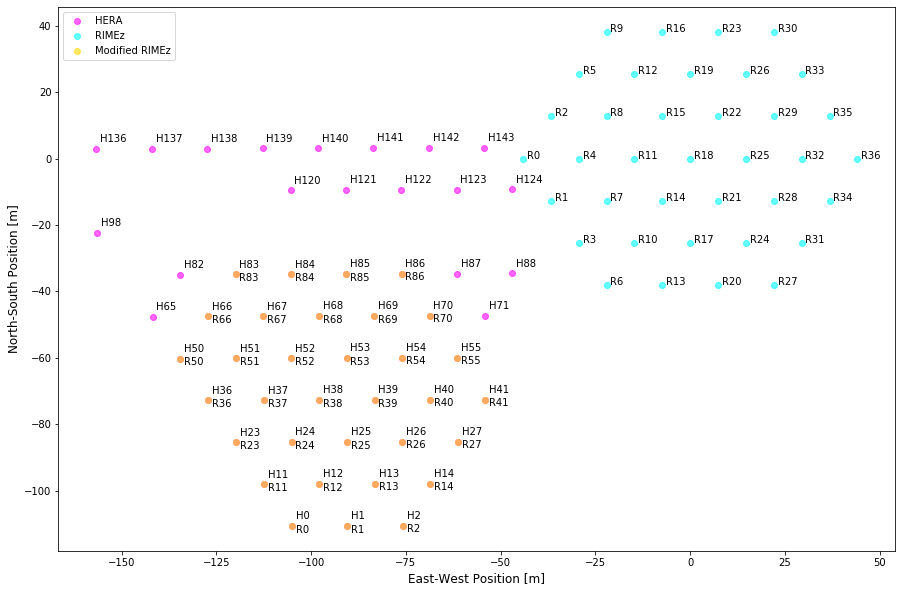

In [27]:
# all on the same plot
plot_kwargs = {'marker' : 'o', 'dx' : 1, 'alpha' : 0.6, 'lw' : 0}
fig = plot_array(
    ref_uvd, recenter=False, figsize=(15,10), dy=2, color='magenta',
    ant_label='H', array_label='HERA', **plot_kwargs
)
ax = fig.axes[0]
update_array_plot(
    ax, base_sim_uvd, recenter=False, dy=0, color='cyan', ant_label='R', 
    array_label='RIMEz', **plot_kwargs
)
update_array_plot(
    ax, sim_uvd, recenter=False, dy=-2, color='gold', ant_label='R',
    array_label='Modified RIMEz', **plot_kwargs
)
_ = ax.legend(loc='upper left')

**Figure 1 |** Plot showing the HERA H1C array (magenta), the original RIMEz array (cyan), and the subset of the RIMEz array used for this validation test (gold). Note that the antenna positions and numbers from the modified RIMEz array exactly match those for the subset of the HERA H1C antennas being used.

In [28]:
# check that data is redundant and nonzero
sim_antpos = _get_array_dict(sim_uvd)
sim_reds = hera_cal.redcal.get_pos_reds(sim_antpos)
for reds in sim_reds:
    combos = itertools.combinations(reds, 2)
    for combo in combos:
        bl1, bl2 = combo
        assert np.allclose(sim_uvd.get_data(bl1), sim_uvd.get_data(bl2))
        assert not np.allclose(sim_uvd.get_data(bl1), 0)

In [29]:
# check how many redundant baselines we keep
base_sim_antpos = _get_array_dict(base_sim_uvd)
h1c_antpos = _get_array_dict(ref_uvd)
base_sim_reds = hera_cal.redcal.get_pos_reds(base_sim_antpos)
h1c_reds = hera_cal.redcal.get_pos_reds(h1c_antpos)
Nreds_kept = len(sim_reds)
f_remain_h1c = int(100 * Nreds_kept / len(h1c_reds))
f_remain_rimez = int(100 * Nreds_kept / len(base_sim_reds))
print(f"{f_remain_h1c}% of H1C unique baselines remain.")
print(f"{f_remain_rimez}% of RIMEz unique baselines remain.")
print(f"{Nreds_kept} unique baselines remain.")

44% of H1C unique baselines remain.
88% of RIMEz unique baselines remain.
56 unique baselines remain.


In [30]:
# check that redcal works
cal_path = str(data_path / "calibrations")
cal = hera_cal.redcal.redcal_run(
    str(sim_file), outdir=str(cal_path), clobber=True
)
for gain_type in ('g_firstcal', 'g_omnical'):
    for gains in cal[gain_type].values():
        assert np.allclose(gains, 1)

Telescope RIMEz calculation is not in known_telescopes.


File exists; clobbering


In [31]:
# check that abscal works
cal_file = str(sim_file).replace('.uvh5', '.omni.calfits')
cal_file = cal_file.replace('visibilities', 'calibrations')
hc = hera_cal.abscal.post_redcal_abscal_run(
    str(sim_file), cal_file, [str(sim_file)], clobber=True
)
assert np.allclose(hc.gain_array, 1)

Telescope RIMEz calculation is not in known_telescopes.




Now calibrating xx-polarization...

    Now calibrating times 2458105.1255731303 through 2458105.1329053952...


Now calibrating yy-polarization...

    Now calibrating times 2458105.1255731303 through 2458105.1329053952...


Mean of empty slice.
invalid value encountered in double_scalars


In [32]:
del cal, hc, base_sim_uvd, ref_uvd, sim_uvd

In [33]:
# # some tests to see if there's any wonky time structure in the rephased visibilities
# # choose a unique baseline to avoid a headache involving choosing the right baseline
# # from the compressed file
# rephased_sim = UVData()
# rephased_sim.read(sim_files[20:60])
# sim = UVData()
# sim.read(vis_file)

In [34]:
# # find out which times from the original simulation to use
# rephased_times = np.unique(rephased_sim.time_array)
# rephased_lsts = np.unique(rephased_sim.lst_array)
# original_times = np.unique(sim.time_array)
# original_lsts = np.unique(sim.lst_array)
# r2o_time_map = hera_cal.abscal.get_d2m_time_map(
#     rephased_times, rephased_lsts, original_times, original_lsts
# )
# sim.select(times=list(r2o_time_map.values()))

In [35]:
# # get the antenna map
# ref_uvd = UVData()
# ref_uvd.read(data_files[0], read_data=False)
# modified_antpos = tools.sim_prep._get_antpos(rephased_sim)
# original_antpos = tools.sim_prep._get_antpos(sim)
# h1c_antpos = tools.sim_prep._get_antpos(ref_uvd)
# array_intersection = tools.sim_prep._get_array_intersection(original_antpos, h1c_antpos)
# r2h_antmap = tools.sim_prep._get_antenna_map(array_intersection, modified_antpos)

In [36]:
# plot_dir = "/users/rpascua/plots/validation/test-4.0.0/fringe_rate_ringing"
# labels = ("Original", "Rephased")
# waterfall_kwargs = {
#     'windows' : 'blackman-harris', 'mode' : 'log', 'cmap' : 'inferno',
#     'limit_drng' : ('delay', 'fringe_rate'), 'dynamic_range' : 5,
#     'baseline' : None, 'horizon_color' : 'white',
#     'plot_limits' : {'delay' : (-1500, 1500), 'fringe_rate' : (-5, 5)},
#     'freq_window_kwargs' : None, 'time_window_kwargs' : None
# }
# for antpair in sim.get_antpairs():
#     ai, aj = antpair
#     if ai not in array_intersection or aj not in array_intersection:
#         continue
#     baseline = array_intersection[aj] - array_intersection[ai]
#     baseline = np.round(baseline, 2)
#     baseline = str(tuple(str(bi) + ' m' for bi in baseline))
#     for label, uvd in zip(labels, (sim, rephased_sim)):
#         title = f"{label} Simulation; ENU Baseline: {baseline}; xx-Pol"
#         save_name = f"{label.lower()}_sim_bl={baseline}.pdf"
#         save_file = os.path.join(plot_dir, save_name)
#         if uvd is sim:
#             antpairpol = antpair + ('xx',)
#         else:
#             antpairpol = tuple(r2h_antmap[ant] for ant in antpair) + ('xx',)
#         vis = uvd.get_data(antpairpol)
#         plot_args = [vis, np.unique(uvd.freq_array), np.unique(uvd.time_array)]
#         lsts = np.unique(uvd.lst_array) * units.sday.to('hr') / (2 * np.pi)
#         waterfall_kwargs['lsts'] = lsts
#         fig = plot_waterfalls(*plot_args, **waterfall_kwargs)
#         fig.text(0.25, 0.9, title, fontsize=14)
#         #fig.tight_layout()
#         fig.savefig(save_file)
#         fig.savefig(save_file.replace('.pdf', '.png'))
#         plt.close()

In [37]:
# vis = sim.get_data((13,6,'xx',))
# original_antpos[13] - original_antpos[6]

In [38]:
# waterfall_kwargs['lsts'] = rephased_lsts * units.sday.to('hr') / (2*np.pi)
# waterfall_kwargs['windows'] = ('blackman-harris',) * 2
# waterfall_kwargs['cmap'] = 'inferno'
# waterfall_kwargs['limit_drng'] = (None,)

In [39]:
# plot_args = [
#     vis, 
#     np.unique(sim.freq_array),
#     np.unique(sim.time_array)
# ]
# fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

In [40]:
# plot_args = [
#     rephased_vis, 
#     np.unique(rephased_sim.freq_array),
#     np.unique(rephased_sim.time_array)
# ]
# fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

In [57]:
# load in the simulation data
start, stop = 20, 40
sim_uvd = UVData()
sim_uvd.read(sim_files[start:stop], axis='blt')
# uncalibrating the data; first, let's choose some baseline and look at the visibilities
antpairpols = [
    antpairpol for antpairpol in sim_uvd.get_antpairpols()
    if antpairpol[0] != antpairpol[1]
]
use_antpairpol = antpairpols[np.random.randint(len(antpairpols))]
ai, aj, pol = use_antpairpol
# check out the orientation of the baseline
sim_antpos = _get_array_dict(sim_uvd)
baseline = sim_antpos[aj] - sim_antpos[ai]
print(use_antpairpol, baseline)

(12, 38, 'nn') [-0.09663295 25.30360649 -0.15966136]


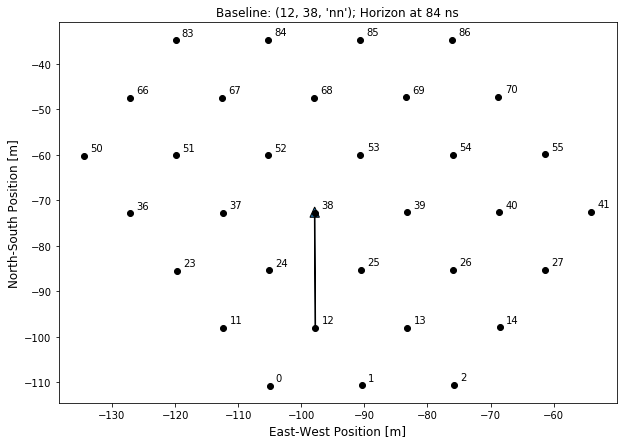

In [58]:
fig = plot_array(sim_uvd, marker='o', color='k', figsize=(10,7), recenter=False)
ax = fig.axes[0]

# get parameters for plotting the baseline
xi, yi, zi = sim_antpos[ai]
dx, dy, dz = baseline

# get the geometric horizon to note in the title
horizon = np.linalg.norm(baseline) / constants.c.value * 1e9 # ns

# make sure that the arrow showing the baseline looks reasonable
tail_width = 0.1
head_width = tail_width * 15
f = 0.96

# actually plot the arrow showing the baseline, as well as the title
_ = ax.arrow(xi, yi, f * dx, f * dy, width=tail_width, head_width=head_width)
_ = ax.set_title(
    f"Baseline: {use_antpairpol}; Horizon at {int(horizon)} ns", fontsize=12
)

In [59]:
waterfall_kwargs = {
    'windows' : 'blackman-harris', 'mode' : 'log', 'cmap' : 'inferno',
    'limit_drng' : ('delay', 'fringe_rate'), 'dynamic_range' : 5,
    'baseline' : None, 'horizon_color' : 'white',
    'plot_limits' : {'delay' : (-1500, 1500), 'fringe_rate' : (-5, 5)},
    'freq_window_kwargs' : None, 'time_window_kwargs' : None
}

In [60]:
# Load in the smoothed, absolutely calibrated visibilities and take a peek.
# ref_files = list(smoothcal_idr2_2_files.values())[0]
# ref_uvd = UVData()
# ref_uvd.read(ref_files[start:stop], axis='blt')

In [61]:
# sim_reds = hera_cal.redcal.get_pos_reds(_get_array_dict(sim_uvd))
# this_red_grp = next(reds for reds in sim_reds if use_antpairpol[:2] in reds)
# ref_antpair = next(ants for ants in ref_uvd.get_antpairs() if ants in this_red_grp)
# ref_antpairpol = ref_antpair + (use_antpairpol[-1],)

In [62]:
# this doesn't work quite right... need to do something else
# plot_args = [
#     ref_uvd.get_data(ref_antpairpol), 
#     np.unique(ref_uvd.freq_array),
#     np.unique(ref_uvd.time_array)
# ]
# fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

In [63]:
# del ref_uvd

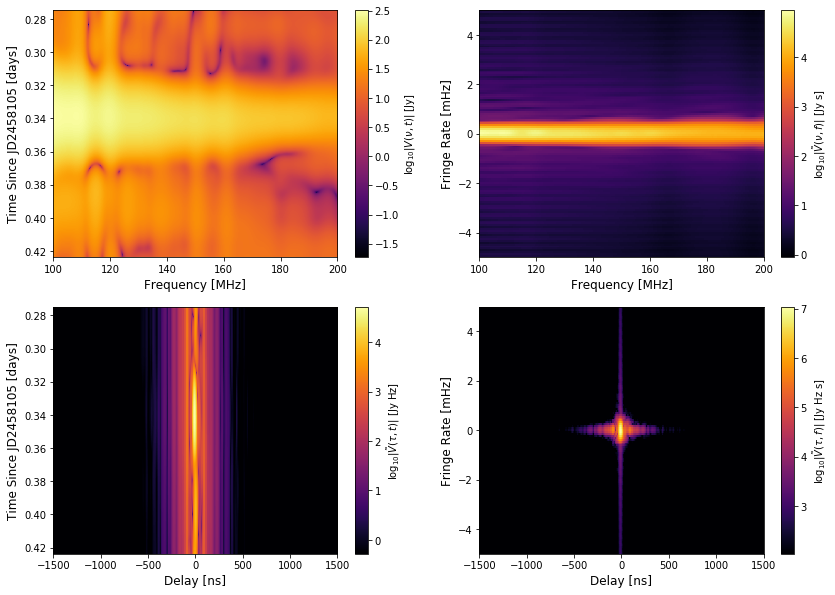

In [64]:
plot_args = [
    sim_uvd.get_data(use_antpairpol), 
    np.unique(sim_uvd.freq_array),
    np.unique(sim_uvd.time_array)
]
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

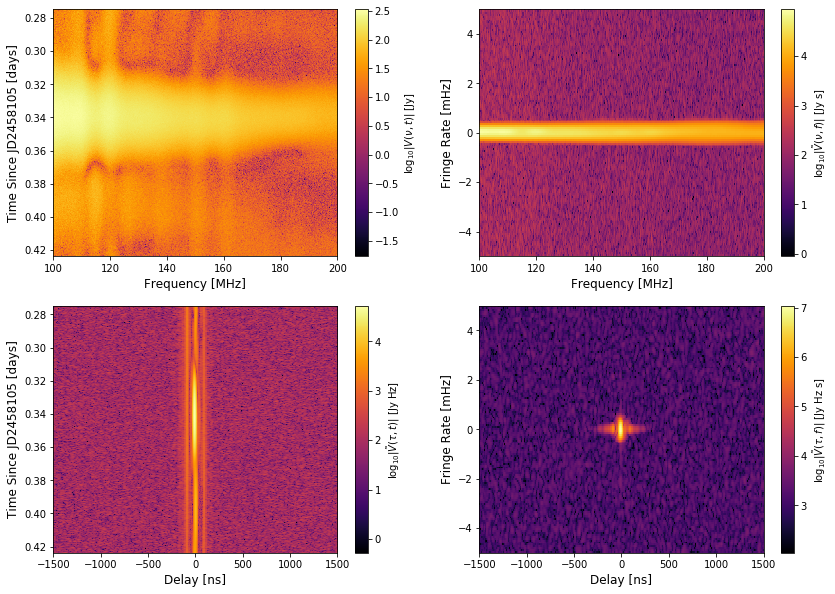

In [65]:
# add some noise
sim_uvd, _ = tools.sim_prep.add_noise(sim_uvd)
sim_uvd = sim_uvd.data
plot_args[0] = sim_uvd.get_data(use_antpairpol)
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

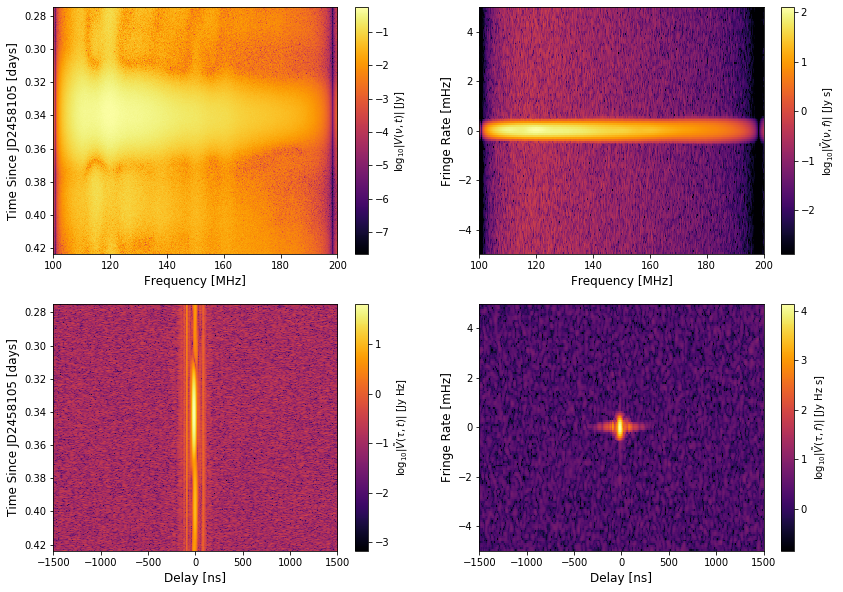

In [66]:
# add bandpass gains
sim_uvd, _ = tools.sim_prep.add_gains(sim_uvd)
plot_args[0] = sim_uvd.get_data(use_antpairpol)
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

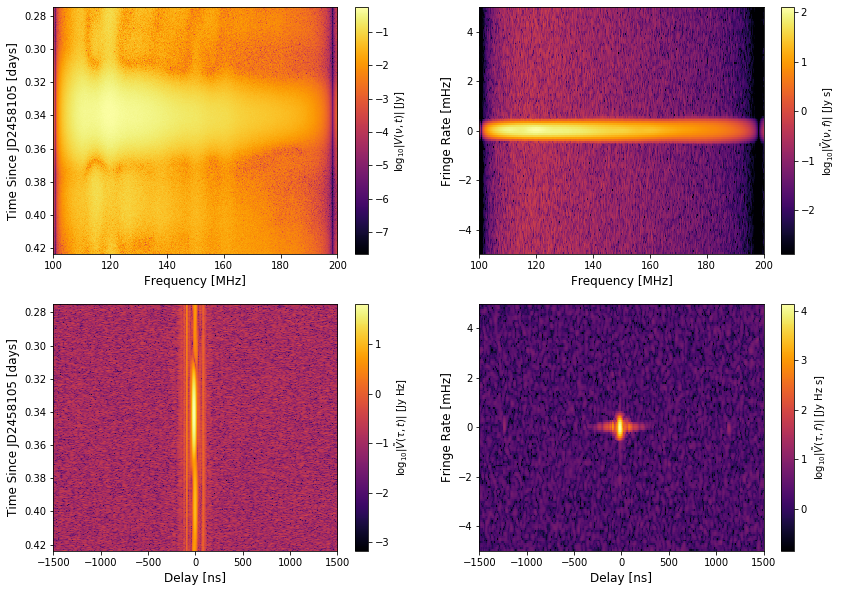

In [67]:
# now for reflections
sim_uvd, _ = tools.sim_prep.add_reflections(sim_uvd, dly_spread=30, amp_scale=1e-4)
plot_args[0] = sim_uvd.get_data(use_antpairpol)
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

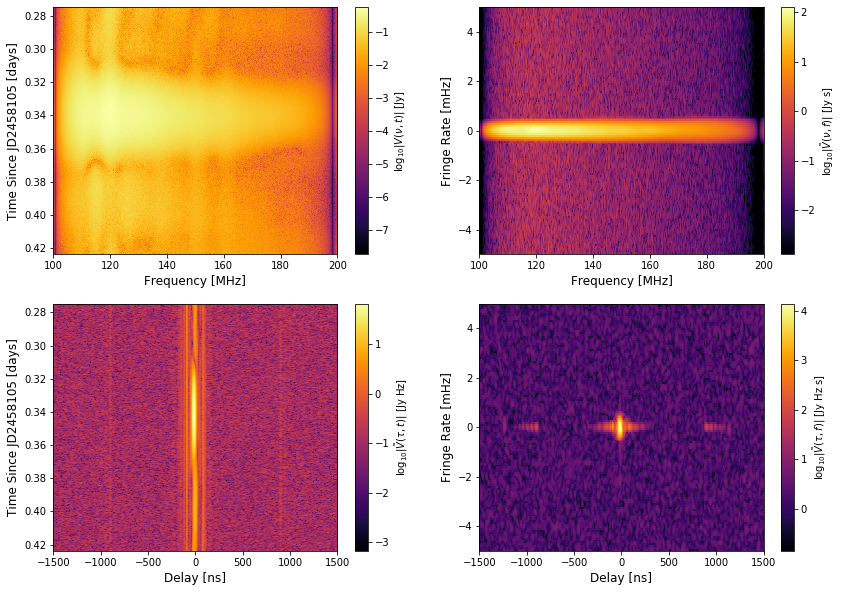

In [68]:
# and finally crosstalk
sim_uvd, _ = tools.sim_prep.add_xtalk(sim_uvd)
plot_args[0] = sim_uvd.get_data(use_antpairpol)
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

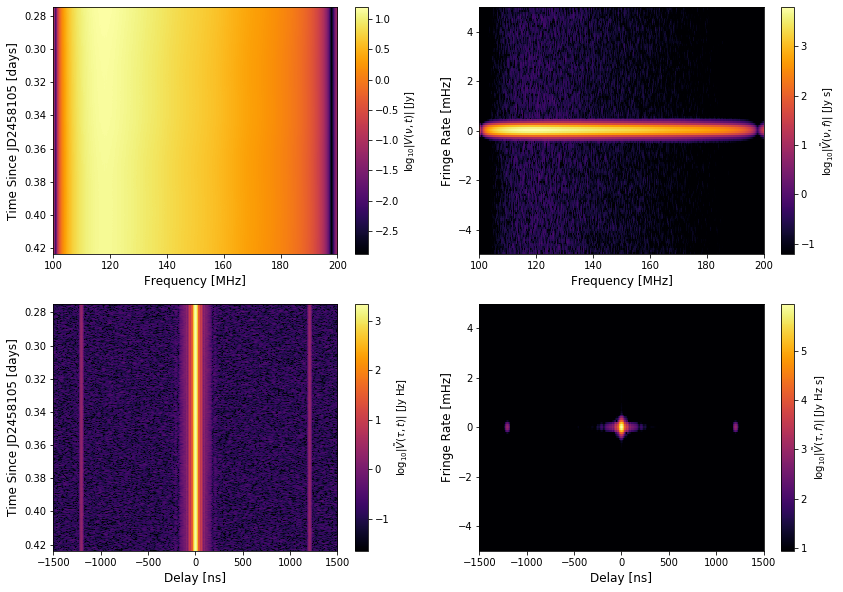

In [69]:
# check out an autocorrelation
plot_args[0] = sim_uvd.get_data(0,0,'xx')
fig = plot_waterfalls(*plot_args, **waterfall_kwargs)

In [70]:
del sim_uvd

## Calibration

## Application of Data RFI Flags

## LST-Binning

## Removal of Systematics and RFI In-Painting

## Power Spectrum Estimation

## Results

### Power Spectrum Results 

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test. 

In [47]:
paths = {key: sorted(glob.glob(str(spec_path / f"*.RR.{kind}.psc"))) for key, kind in zip(['eor', 'fg', 'sum'], ['eor', 'foregrounds', 'true'])}

Let's check how many power spectra we have on disk for each kind: 

In [48]:
for path_list in paths.values():
    print(len(path_list))

0
0
0


Set up a dictionary to house the spectra for all spectral windows: 

In [49]:
spectra = {}

In [50]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

for label, path in paths.items():
    for pth in path:
        
        uvp = get_pspec(pth)
        uvp.fold_spectra()
        
        if label not in spectra:
            spectra[label] = {spw: defaultdict(list) for spw in uvp.spw_array}
            
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            spectra[label][spw][blp].append(uvp.get_data(key))

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.8 µs


In [51]:
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(len(spw_edges))]
dlys = [uvp.get_dlys(j) for j in range(len(spw_edges))]

NameError: name 'uvp' is not defined

In [ ]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (66, 99) corredsponding to (Ntimes, Nkpara)

spectra_avg = {}
for label, spec_dict in spectra.items():
    spectra_avg[label] = {}
    
    for spw, spec_by_spw in spec_dict.items():
        spectra_avg[label][spw] = {}
        
        bl_avg = 0
        for blp, spec in spec_by_spw.items():
            # assert all(s.shape == (66, 99) for s in spec)

            # Reshape the spectra so we can do an easier average.
            # New arrays have the shape (Nfiles*Ntimes, Nkpara)
            spec = np.array(spec)
            spec_by_spw[blp] = spec.reshape((-1, spec.shape[-1]))
            
            spectra_avg[label][spw][blp] = np.mean(spec_by_spw[blp], axis=0)
            bl_avg += spectra_avg[label][spw][blp]
            
        spectra_avg[label][spw]['average'] = bl_avg / len(spec_dict[0])

In [ ]:
Nkinds = len(spectra)
Nspws  = len(spectra['eor'])
Nblps  = len(spectra['eor'][0])

In [ ]:
# now get the expected power spectrum for each spectral window
aliased_spectra = {spw: get_analytic_spectrum(uvp, spw) for spw in uvp.spw_array}

In [ ]:
plot_avg_spectra(spectra_avg, aliased_spectra);

**Figure 2** | Power spectra for the three spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. We only see EoR dominate the signal at some $k$-modes in the upper spectral window. 

In [ ]:
# Plot residual
plot_avg_spectra(spectra_avg, aliased_spectra, resid=True, xlim=(0.2, 3), ylim=(-0.5, 0.5))

**Figure 3** | Fractional residuals, measured relative to the analytic power spectrum. Note that at low frequencies, the EoR is too weak to be detected at any $k_{||}$. At higher frequencies, the estimate of the spectrum of the sum conforms both to the analytic power and the eor power (i.e. foreground power is not being thrown out to arbitrarily high $k_{||}$). 